## This notebook was created by the tectonic geomorphology group at ESPIn 2021. In this tutorial, we will discuss and execute a model featured in Reitman et al. (2015) that simulates strike-slip faulting. We will then demonstrate a simple method for modifying Reitman et al. (2015)'s model to simulate oblique-slip faulting. The model's code and the paper's simulation information can be found here: https://zenodo.org/record/3374026#.YMfJpTZudUN

### Reitman et al. (2019) use a landscape evolution model to investigate how accurately stream channels record strike-slip fault displacement. In detail, they assess how fault zone width, earthquake recurrence interval, the recurrence interval coefficient of variation, and the total slip affect both accuracy and variability of individual offset measurements and of populations of offset measurements. The modeling approach is particularly advantageous for this problem because it allows assessment of both precision and accuracy of offset measurements because the true, complete slip history is known. The authors find that while individual offset measurements vary considerably, the mean values of large samples of offset measurements generally recover the true slip value. This is not the case for all model scenarios, however: wide fault zones, total slip greater than channel spacing, and recurrence intervals greater than ~3,500 years all result in significant underestimates of total slip. The authors also evaluate how the topography in the geomorphic fault zone develops following earthquakes. They find that the aspect ratio of the topography increases sharply with each earthquake, then continues to increase slowly for a short period of time following the earthquake as erosion occurs in the fault zone. During the interseismic period, the aspect ratio decreases as stream channels adjust, eventually approaching a value slightly greater than the pre-earthquake aspect ratio.

### To begin, create and activate a conda environment with the following packages installed: numpy, matplotlib, scipy, scikit-image, scikit-learn, pickle, yaml, rasterio, landlab. We will then import packages and set some plotting configurations.

In [1]:
import time, os                       # track run time, chdirs, read args from command line
import numpy as np                         # math with numpy
import yaml                                # for reading in a parameter file
import matplotlib.pyplot as plt            # plot with matplotlib
import matplotlib.colors as colors
plt.rcParams['axes.facecolor'] =(1,1,1,1)  # white plot backgrounds
plt.rcParams['figure.facecolor']=(1,1,1,0) # clear figure backgrounds
plt.rcParams['xtick.top']=True # plot ticks on top
plt.rcParams['ytick.right']=True # plot ticks on right side
plt.rcParams['ytick.direction']='in' # tick marks face in
plt.rcParams['xtick.direction']='in' # tick marks face in
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from skimage import measure
import rasterio as rio

import warnings
warnings.filterwarnings('ignore')

from slip import calcSlipRegime, calcOFD, calcCOV # my function for making tectonic regimes and ofd profiles

from landlab import RasterModelGrid, imshow_grid # landlab grid components
from landlab.components import LinearDiffuser, DepressionFinderAndRouter
from landlab.components import FlowAccumulator, FastscapeEroder
import pickle as pickle
from landlab.io import read_esri_ascii 

### Next, we'll set various parameters called by the model.

In [2]:
# time parameters
dt = 1 # timestep in years
tmax = 10 # total time in years

# grid parameters
xmax = 1000 # x grid dimension in meters
ymax = 500 # y grid dimension in meters
dxy = 1.0 # grid step in meters

# geomorph parameters
kappa = 0.01 # hillslope diffusivity; bob says this is good value for DV alluvium. see Nash, Hanks papers. m2/yr diffusivity / transport coefficient for soil diffusion
K_sp = 0.003 # stream power for FastscapeEroder
threshold = 0.00005 # threshold for FastscapeEroder
m = 0.5                 # exponent on area in stream power equation
n = 1.                  # exponent on slope in stream power equation

# strike-slip parameters
slip_interval = 1 # how often an earthquake occurs [years]
total_slip = 10. # total slip for entire model time [meters]
slip_type = 'characteristic' # slip type for calc slip regime function. options are characteristic, creep, random_time, random_slip, random_random
control = False # make a model with no tectonics to compare how landscape acts without perturbations
uplift_rate = 0.001 # background relative rock uplift rate [m/yr]
std = 0
seed = 123456
slip_regime = None

# ofd parameters
fault_zone_width = 0.000001 # define width of fault zone (ofd zone) in meters. use 0.000001 for none b/c otherwise get divide by zero error. (distance from fault on either side) [is this half or total? --> total, but not actually used. only used to get ystar = fzw/5]
y_star = fault_zone_width/7. # length scale of OFD decay [meters].

# plotting parameters (grid plotting & initial conditions)
figsize = [10,8] # size of grid plots
shrink = 0.35 # amount of colorbar shrinkage for plots (0-1). 1 = not shrunk. 0 = nonexistent.
limits = [0,20] # elevation limits for grid plots
plots = 100 # how often to save a frame for the movie. 1 = every timestep.

model_time = np.arange(0,tmax,dt) # Set model time parameters

### Before running the model, we need to initialize the model grid. An instance of the grid will be used to populate various parameters and visualize initial condition topography prior to the simulation. We will use a DEM provided by Reitman et al. (2015) as the model's initial condition.

In [3]:
(grid, z) = read_esri_ascii('ztopo_1000x500y1.asc',name='topographic__elevation') 
nrows = int(ymax/dxy)
ncols = int(xmax/dxy)

### Let's take a look at our initial condition model domain.

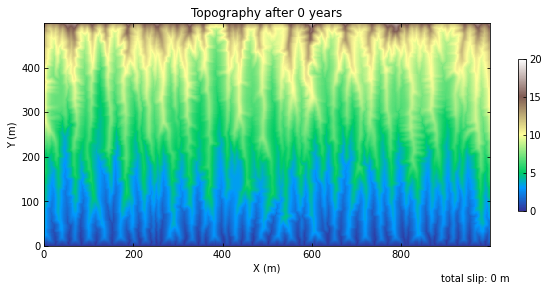

In [4]:
fig = plt.figure(figsize=figsize)
imshow_grid(grid,z,cmap='terrain',limits=limits,grid_units=['m','m'],shrink=shrink)
plt.title('Topography after 0 years')
plt.text(xmax-110,-80, 'total slip: 0 m')
plt.show()

### Now, we need to initiallize various tectonics-related parameters and structures that will allow us to simulate strike-slip faulting and track displacement along the fault.

In [5]:
# Set tectonic parameters
fault_loc = int(ymax / 2.) # EDITED LINE; Remove 'np.'
# row of nodes that are main fault trace
fault_nodes = np.where(grid.node_y==fault_loc)[0]
# make a slip regime and slip_per_event
slip_regime, slip_per_event = calcSlipRegime(tmax, dt, slip_interval,
                                             std=std, total_slip=total_slip,
                                             slip_type=slip_type, seed=seed)

# calculate COV of slip_regime
cov = calcCOV(slip_regime,dt)

# calculate cumulative_slip
cumulative_slip = np.zeros((len(model_time)),dtype=float)
for i in range(len(model_time)-1):
    if slip_regime[i] > 0:
        cumulative_slip[i] += slip_regime[i]
    cumulative_slip[i+1] = cumulative_slip[i]
    
max_slip = slip_per_event # [meters]

# calculate ofd slip profile, this is length(nrows)
ofd_profile = calcOFD(fault_zone_width,max_slip,fault_loc,y_star,dxy,ymax,nrows,plot=False)

###### SET UP TO TRACK DISPLACEMENT #############
# because the grid is discretized into pixels, we need to count how much deformation has occurred over an earthquake
# and move a pixel after the accumulated deformation is larger than than the pixel length
accum_disp = np.zeros(nrows) # start with no accumulated displacement
accum_disp_total = np.zeros(shape=(nrows,ncols)) # also track total accumulated displacement
displacement = grid.add_zeros('node','accumulated__displacement') # add field to grid to track accumulated displacement

# This is an array for counting how many pixels need to be moved
nshift = np.zeros(nrows,dtype=int)

# set start time for keeping track how long a run takes
start_time = time.time()

# calculate number of iterations based on total time
iterations = len(model_time)

slip rate is 1.0 m/yr
total slip is 10.0 meters
creeping
total slip slipped is 10.0 meters in 10 earthquakes


### Let's see the slip scenario that we just designed for our model. You'll notice that, for this scenario, the slip rate is constant through time.

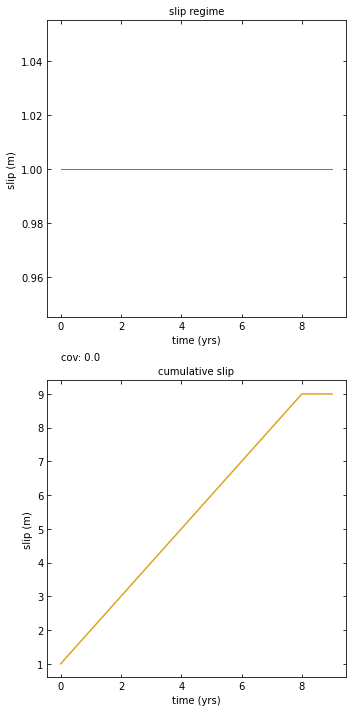

In [6]:
# plot slip_regime and cumulative slip
fig = plt.subplots(2,1, figsize=(5,10))
ax1 = plt.subplot(2,1,1)
ax1.plot(model_time, slip_regime,color='steelblue',linewidth=1.0)
ax1.set_ylabel('slip (m)')
ax1.set_xlabel('time (yrs)')
ax1.set_title('slip regime',fontsize=10)
ax2 = plt.subplot(2,1,2)
ax2.plot(model_time,cumulative_slip,color='goldenrod')
ax2.set_ylabel('slip (m)')
ax2.set_xlabel('time (yrs)')
ax2.set_title('cumulative slip',fontsize=10)
ax2.text(0,10,'cov: %s' %cov)
plt.tight_layout()
plt.show()

### Alternatively, the displacement that our designed simulation will perform can be viewed in plan-view.

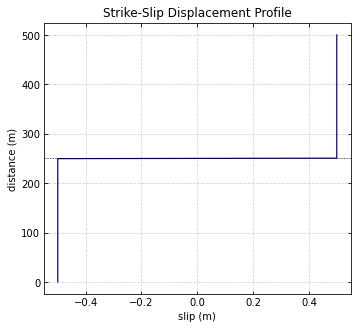

In [7]:
# plot ofd profile
fig = plt.subplots(figsize=(5.5,5))
plt.plot(ofd_profile,np.linspace(0,ymax,nrows),color='navy',linewidth=1.2)
plt.axhline(fault_loc,0,1,color='k',linestyle='--',linewidth=0.5)
plt.grid(color='lightgray',linestyle='--')
plt.ylabel('distance (m)')
plt.xlabel('slip (m)')
plt.title('Strike-Slip Displacement Profile')
plt.show()

### Now, let's define a function that will run the model's main loop. The function includes a uniform background rock uplift rate that is applied to the grid's elevation at each timestep along with fluvial and linear hillslope erosion. By default, the vertical displacement value is spatially and temporally uniform (the background rock uplift rate). However, we will demonstrate how to create and apply a custom rock uplift rate field that simulates oblique-slip faulting.

In [8]:
def main_loop(uplift_fault=np.reshape(z[:],[nrows,ncols])*0):
    
    (grid, z) = read_esri_ascii('ztopo_1000x500y1.asc',name='topographic__elevation') 
    grid.set_closed_boundaries_at_grid_edges(False, False, False, False) # Boundary conditions

    # Assign global variables
    global accum_disp, accum_disp_total, ofd_profile, dt, nrows, ncols, displacement, iterations
    
    # Initialize landlab components
    linear_diffuser = LinearDiffuser(grid,linear_diffusivity=kappa) # hillslope diffusion
    flow_router = FlowAccumulator(grid, flow_director='D8')
    fill = DepressionFinderAndRouter(grid)
    fastscape_eroder = FastscapeEroder(grid,K_sp=K_sp, m_sp=m, n_sp=n, threshold_sp=threshold) # stream power erosion
    
    # starting an eq counter for the random tectonic regimes
    # b/c max_slip is same length as number eq,
    # so need to access the right value of max_slip (i.e., the max_slip for that eq)
    eq_counter = 0
    
    #timesteps_between_eqs = 0

    for i in range(iterations):

        # if this is a time when tectonics happens, do tectonics
        if slip_regime[i] > 0:

            # Take the landlab grid elevations and reshape into a box nrows x ncols
            z_reshape = np.reshape(z[:],[nrows,ncols])
        
            # Scale uplift_fault
            uplift_fault = uplift_fault
            
            # Calculate the offset that has accumulated for this time/event
            # this is used to cound how much to shift the grid for this time/event
            # after slip happens, the amount slipped is subtracted from accum_disp
            if len(ofd_profile) == nrows: 
                accum_disp += ofd_profile
                for j in range(ncols): accum_disp_total[:,j]+= ofd_profile

            else:
                accum_disp += ofd_profile[eq_counter,:]
                for j in range(ncols): accum_disp_total[:,j]+= ofd_profile[eq_counter,:]


            # keep track of total accumulated displacement
            accum_disp_total_reshape = np.reshape(accum_disp_total,nrows*ncols)

            # save total accumulated displacement in a field on the grid
            displacement[:] = accum_disp_total_reshape

            # count number of pixels to be moved this time/event
            nshift[:] = np.floor(accum_disp/dxy)
            
            # now scan up the landscape row by row looking for offset
            for r in range(nrows): # change xrange to range for Py3

                # check if the accumulated offset for a row is larger than a pixel
                if accum_disp[r] >= dxy or accum_disp[r] <= -dxy:

                    # move the row over by the number of pixels of accumulated offset
                    z_reshape[r,:] = np.roll(z_reshape[r,:],nshift[r])

                    # subtract the offset pixels from the displacement
                    accum_disp[r] -= dxy * nshift[r]

            # Add uplift field to the reshaped elevation grid
            z_reshape += np.flipud(uplift_fault)*dt # Not sure dt should be here

            # Reshape the elevation box into an array for landlab
            z_new = np.reshape(z_reshape, nrows*ncols)

            # feed new z back into landlab
            z[:] = z_new

            # move the eq_counter ahead
            eq_counter += 1

            #timesteps_between_eqs = 0
        if i%3 == 0:
            imshow_grid(grid,z,cmap='terrain',limits=limits,grid_units=['m','m'],shrink=shrink)
            plt.show()

        
        #timesteps_between_eqs += 1

        # now do the landscape evolution stuff
        # diffuse landscape via soil diffusion
        linear_diffuser.run_one_step(dt)
        # calculate flow routes across new landscape
        flow_router.run_one_step()
        # erode landscape based on routed flow and stream incision
        fastscape_eroder.run_one_step(dt)
        # uplift by background uplift rate
        z[:] += uplift_rate * dt
        # make sure bottom row stays at 0 elevation
        z[grid.node_y==0] = 0
        
    # Return the elevation grid
    z_reshape = np.flipud(np.reshape(z[:],[nrows,ncols]))
    return z_reshape, grid

### Here, we reproduce Reitman et al. (2015)'s results by running a simulation with right-lateral displacement and a uniform background rock uplift rate. Several time slices are extracted from the model's run.

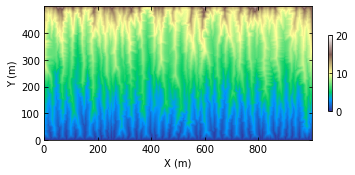

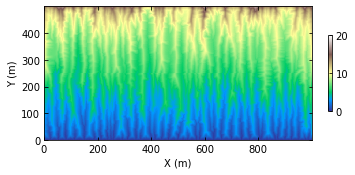

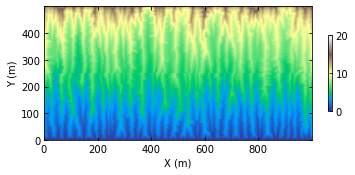

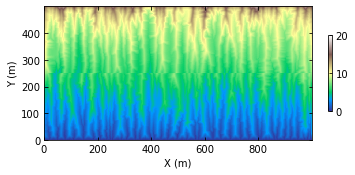

In [9]:
def_run_topo, grid = main_loop()

# Creating a custom uplift rate field to simulate oblique slip:
### Our uplift rate field will be a grid of the same shape as the model domain. Each cell within the grid will contain a rock uplift rate value that will then be applied to the corresponding node in the model grid within the 'main_loop' function. To create a smoothly varrying grid of rock uplift rates, we first define the uplift rate along two rows: one just north of the fault and one just south of the fault. We then interpolate uplift rates from the fault to the grid's boundaries.

In [10]:
# Create new uplift rate field
north_of_fault__uplift_rate = np.ones(grid.number_of_node_columns)
peak_u_idx = int(len(north_of_fault__uplift_rate)/5) # Have the peak uplift rate occur at 1/3 of the fault's length
north_of_fault__uplift_rate[:peak_u_idx] = np.log(np.arange(500,peak_u_idx+500))-5 # This is where we assign the magnitude of rock uplift rate
l = len(north_of_fault__uplift_rate)-peak_u_idx

# Uplift rate along a row just north of the fault
north_of_fault__uplift_rate[peak_u_idx:] = np.linspace(north_of_fault__uplift_rate[peak_u_idx-1],1,l)
north_of_fault__uplift_rate -= north_of_fault__uplift_rate[int(len(north_of_fault__uplift_rate)/2)]

# Uplift rate along a row just south of the fault
south_of_fault__uplift_rate = np.flipud(north_of_fault__uplift_rate)

### Let's see the uplift rates we've just created that will border the northern and southern side of the fault.

Text(0, 0.5, 'm/yr')

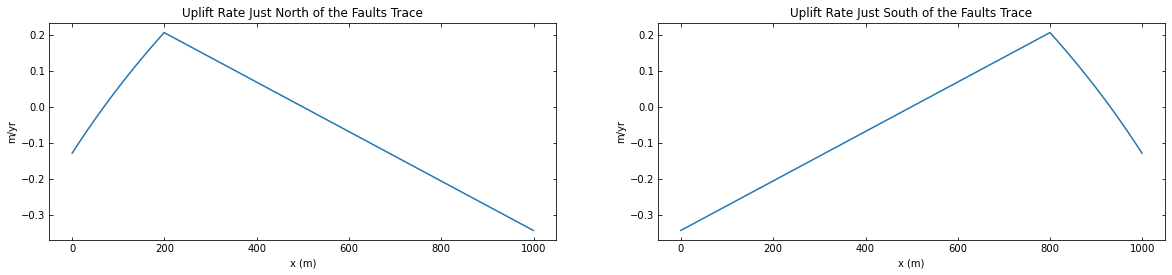

In [11]:
fig = plt.subplots(1,2,figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(north_of_fault__uplift_rate)
plt.title('Uplift Rate Just North of the Fault''s Trace')
plt.xlabel('x (m)')
plt.ylabel('m/yr')

plt.subplot(1,2,2)
plt.plot(south_of_fault__uplift_rate)
plt.title('Uplift Rate Just South of the Fault''s Trace')
plt.xlabel('x (m)')
plt.ylabel('m/yr')

### Now all we have to do is add these uplift rates to a grid made of zeros that is of the same size as the model domain. We can then interpolate uplift rates from the grid's center to its boundaries.

In [12]:
# Initialize the grid storing oblique slip uplift rate values
uplift_fault = np.zeros([nrows, ncols])
uplift_fault[250,:] = north_of_fault__uplift_rate
uplift_fault[251,:] = south_of_fault__uplift_rate

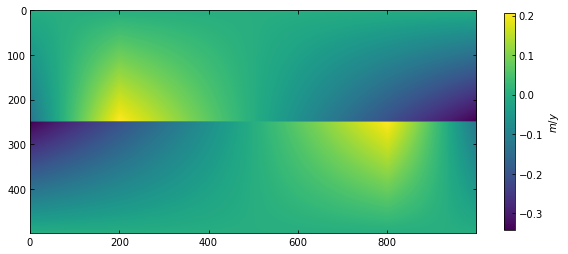

In [13]:
# Fill in the rock uplift rate values by interpolating from the center rows to the edges for each column.
for i in range(uplift_fault.shape[1]):
    uplift_fault[:250,i] = np.linspace(0,uplift_fault[250,i],250)
    uplift_fault[251:,i] = np.linspace(uplift_fault[251,i],0,249)
    
# Plot the uplift rate field
fig = plt.figure(figsize=figsize)
plt.imshow(uplift_fault)
plt.colorbar(shrink=.5,label=r'$m/y$')

### Awesome! Now let's run a simulation using our newly-constructed uplift rate field as the input to the 'main_loop' function.

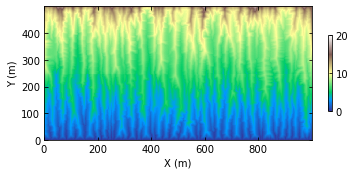

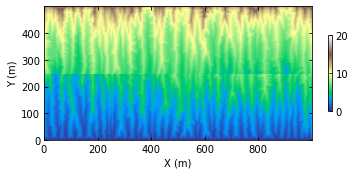

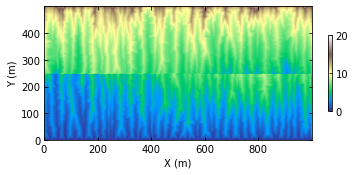

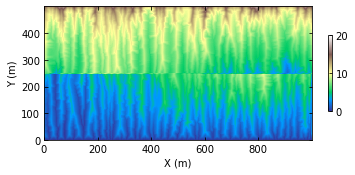

In [14]:
uplift_run_topo, grid = main_loop(uplift_fault)

### To visualize how the custom uplift rate field influences topography, let's plot the difference between the output of the oblique slip run and the uniform background rock uplift rate run.

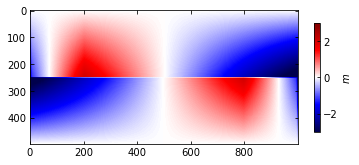

In [15]:
topo_diff = uplift_run_topo - def_run_topo
plt.imshow(topo_diff,cmap='seismic',vmax = 3, vmin = -3)
plt.colorbar(shrink=.5,label=r'$m$')

### Now let's see how incorporating spatially variable rock uplift influences the fluvial network throughout our domain.

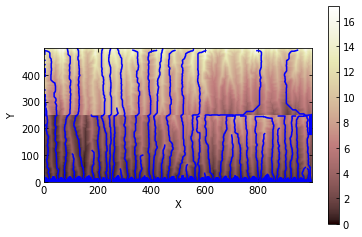

In [16]:
from landlab.components import ChannelProfiler, FlowAccumulator

# Update flow accumulator
fr = FlowAccumulator(grid, flow_director='D8',depression_finder='DepressionFinderAndRouter')
fr.run_one_step()
    
# Plot channel profiles
profiler = ChannelProfiler(grid, number_of_watersheds = 800)
profiler.run_one_step()
            
plt.figure()
imshow_grid(grid,"topographic__elevation")

riv_nodes = profiler.nodes

for i in range(len(riv_nodes)):
            
    riv_x = grid.x_of_node[riv_nodes[i]]
    riv_y = grid.y_of_node[riv_nodes[i]]

    plt.plot(riv_x,riv_y,color='b')




### As you can see, horizontal offset in the fluvial network is variable despite uniform magnitude of total slip along the fault. In some cases, river offset even mimics left-lateral slip (see river in upper right corner)! Our simulations suggest that individual river offsets in oblique-slip fault systems can be misleading indicators of the magnitude and direction of horizontal displacement.